## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   loss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [1]:
%load_ext lab_black

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm  # <- para graficar la barra de avance

#### configuramos el `device` acorde al device disponible




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Cargar base de datos

In [15]:
basepath = "/tf/notebooks/CEIA-deep_learning/clase_5/data"


class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def custom_dataloader(data_file, label_file, batch_size=512):
    data = np.load(os.path.join(basepath, data_file), allow_pickle=True)
    data = np.expand_dims(data, axis=1)
    labels = np.load(os.path.join(basepath, label_file), allow_pickle=True)
    dataset = CustomDataset(data, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


dataloader = {
    "train": custom_dataloader("train.pkl", "train_label.pkl"),
    "val": custom_dataloader("val.pkl", "val_label.pkl"),
    "test": custom_dataloader("test.pkl", "test_label.pkl"),
}

2. Ver que la base de datos esté OK

In [16]:
print(type(dataloader))
print(type(dataloader["train"]))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


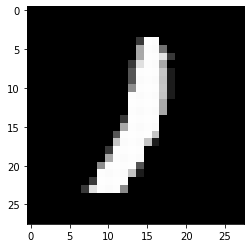

Label: 1


In [17]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader["train"]))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print("tamaño de 1 imagen: ", img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print("tamaño 1 imagen DESPUES de squeeze: ", img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

3. Construyo mi CNN

In [63]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=7, padding="same", stride=1
        )
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=32 * 14 * 14, out_features=10)
        self.to(device)

    def forward(self, input):
        out = self.conv1(input)
        out = self.relu(out)
        out = self.pool1(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def fit(self, dataloader, epochs=10, lr=1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        for epoch in range(epochs):
            self.train()
            train_loss, train_acc = [], []
            bar = tqdm(dataloader["train"])
            for batch in bar:
                X, y = batch
                X, y = X.to(device).float(), y.to(device).long()
                optimizer.zero_grad()
                y_pred = model(X)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                ####
                acc = (y == torch.argmax(y_pred, axis=1)).sum().item() / len(y)
                train_acc.append(acc)
                bar.set_description(
                    f"Epoch {epoch+1}/{epochs}:\tloss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}"
                )

            self.eval()
            val_loss, val_acc = [], []
            bar = tqdm(dataloader["test"])
            with torch.no_grad():
                for batch in bar:
                    X, y = batch
                    X, y = X.to(device).float(), y.to(device).long()
                    y_pred = model(X)
                    loss = criterion(y_pred, y)
                    val_loss.append(loss.item())
                    acc = (y == torch.argmax(y_pred, axis=1)).sum().item() / len(y)
                    val_acc.append(acc)
                    bar.set_description(
                        f"\t\tval_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}"
                    )

In [61]:
model = CNN()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           1,600
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                   [-1, 10]          62,730
Total params: 64,330
Trainable params: 64,330
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.25
Estimated Total Size (MB): 0.73
----------------------------------------------------------------


In [62]:
model.fit(dataloader)

Epoch 1/10:	loss 7.23879 acc 0.85196: 100% 110/110 [00:00<00:00, 133.61it/s]
	val_loss 0.53987 val_acc 0.95509: 100% 14/14 [00:00<00:00, 228.36it/s]
Epoch 2/10:	loss 0.32943 acc 0.96471: 100% 110/110 [00:00<00:00, 136.79it/s]
	val_loss 0.31751 val_acc 0.96759: 100% 14/14 [00:00<00:00, 227.42it/s]
Epoch 3/10:	loss 0.16151 acc 0.97597: 100% 110/110 [00:00<00:00, 127.90it/s]
	val_loss 0.25017 val_acc 0.97177: 100% 14/14 [00:00<00:00, 184.96it/s]
Epoch 4/10:	loss 0.09796 acc 0.98195: 100% 110/110 [00:00<00:00, 132.34it/s]
	val_loss 0.21055 val_acc 0.97273: 100% 14/14 [00:00<00:00, 228.80it/s]
Epoch 5/10:	loss 0.06355 acc 0.98581: 100% 110/110 [00:00<00:00, 132.18it/s]
	val_loss 0.20224 val_acc 0.97400: 100% 14/14 [00:00<00:00, 222.24it/s]
Epoch 6/10:	loss 0.04505 acc 0.98882: 100% 110/110 [00:00<00:00, 135.55it/s]
	val_loss 0.17704 val_acc 0.97672: 100% 14/14 [00:00<00:00, 220.65it/s]
Epoch 7/10:	loss 0.03059 acc 0.99134: 100% 110/110 [00:00<00:00, 135.51it/s]
	val_loss 0.16823 val_acc 0.9

# score final